# Attention Mechanism

## Library

In [8]:
import numpy as np
import pandas as pd 
from  tensorflow.keras.preprocessing.text import Tokenizer #Xử lý văn bản với Keras
from  tensorflow.keras.preprocessing.sequence import pad_sequences 
import matplotlib.pyplot as plt

import torch   # hỗ trợ xây dựng và huấn luyện các mô hình mạng nơ-ron.
import torch.nn as nn   #cung cấp các lớp cơ bản để xây dựng mạng nơ-ron như các lớp tích chập (convolutional),
                        # các lớp kết nối đầy đủ (fully connected), và các lớp Recurrent Neural Networks (RNN).
import torch.nn.functional as F  # cung cấp các hàm kích hoạt và các phép biến đổi thường được sử dụng trong mạng nơ-ron như ReLU, softmax.
from torch import optim   # chứa các phương pháp tối ưu hóa như SGD, Adam, được sử dụng để cập nhật trọng số của mô hình trong quá trình huấn luyện.
from torch.autograd import Variable   # cho phép theo dõi sự thay đổi của tensor trong quá trình huấn luyện để tính gradient tự động.
from sklearn.model_selection import train_test_split
import torch.utils.data    # cung cấp các công cụ để thao tác với dữ liệu, như DataLoader, rất hữu ích trong việc huấn luyện mô hình với dữ liệu theo lô (batches).
import matplotlib.ticker as ticker
from random import randint #Hàm từ thư viện random, dùng để tạo số nguyên ngẫu nhiên trong một khoảng cho trước.


c:\Users\Lewis Do\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
! curl --silent -L -o data.zip "https://drive.google.com/uc?export=download&id=1d6eUqRstk7NIpyASzbuIsDvBdHEwfU0g"
! unzip -q data.zip
! ls data

data.csv
human_vocab.json
machine_vocab.json


## Preprocessing

#### Vocab dataset we are using is alphabets and numerics. No need to filter

In [25]:
def load_data(path):
    df = pd.read_csv(path, header=None)
    X = df[0].values
    y = df[1].values
    
    # khoi tao Tokenizer vaf chuyen doi van ban thanh chuoi so nguyen
    x_tok = Tokenizer(char_level=True, filters='')
    x_tok.fit_on_texts(X)
    y_tok = Tokenizer(char_level=True, filters='')
    y_tok.fit_on_texts(y)
     
    # chuyen van ban thanh chuoi cac so nguyen
    X = x_tok.texts_to_sequences(X)
    y = y_tok.texts_to_sequences(y)

    # padding chuoi (neu can thiet)
    X = pad_sequences(X)

    # chuyen nhan y thanh chuoi numpy
    y = np.asarray(y)

    return X, y, x_tok.word_index, y_tok.word_index

In [27]:
X, y ,x_wid, y_wid = load_data('data/data.csv')

# tao dict nguoc de anh xa tu so nguyen ve ki tu
x_id2w = dict(zip(x_wid.values(), x_wid.keys()))
y_id2w = dict(zip(y_wid.values(), y_wid.keys()))

X_train, X_test, y_train, y_test = train_test_split(X, y)
print('train size :{} - test size: {}'.format(len(X_train), len(X_test)))

train size :18750 - test size: 6250


### Defines parameters

In [28]:
# hidden size for LSTM
hidden_size = 128  # xác định số lượng tế bào nơ-ron trong tầng ẩn. 
                   # Kích thước này càng lớn, mô hình càng có khả năng ghi nhớ và xử lý các mẫu phức tạp, 
                   # nhưng nó cũng sẽ tốn nhiều tài nguyên tính toán hơn.
learning_rate = 0.001
decoder_learning_ratio = 0.1

#  sentences of vocab input
input_size = len(x_wid) + 1 # ki tu padding

output_size = len(y_wid) + 2 # can 2 ki tu bat dau va ket thuc

sos_idx = len(y_wid)
eos_idx = len(y_wid) + 1

max_length = y.shape[1]
print("input vocab: {} - output vocab: {} - length of target: {}".format(input_size, output_size, max_length))


input vocab: 35 - output vocab: 13 - length of target: 10


In [30]:
def decoder_sentence(idxs, vocab):
    text = ''.join([vocab[w] for w in idxs if (w > 0) and (w in vocab)])
    return text

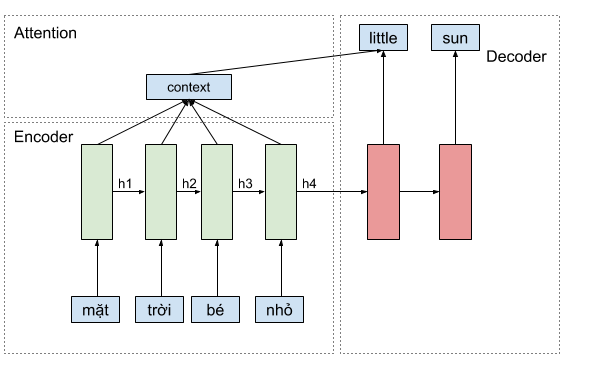

In [33]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size) -> None:
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        # embedding vocab's vector
        self.embedding = nn.Embedding(input_size, hidden_size)
        # GRU
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input):
        # input: SxB
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded)
        return output, hidden # SxBxH, 1xBxH
    
class Attn(nn.Module):
    def __init__(self, hidden_size):
        super(Attn, self).__init__()
    

    def forward(self, hidden, encoder_outputs):
        ### Mô hình nhận trạng thái hidden hiện tại của mô hình decoder, 
        ### và các hidden states của mô hình encoder
        # encoder_outputs: TxBxH
        # hidden: SxBxH
        
        # tranpose về đúng shape để nhận ma trận
        encoder_outputs = torch.transpose(encoder_outputs, 0, 1) # BxTxH
        hidden = torch.transpose(torch.transpose(hidden, 0, 1),1, 2) # BxHxS

        # tính e, chính là tương tác giữ hidden và các trạng thái ẩn của mô hình encoder 
        energies = torch.bmm(encoder_outputs, hidden) # BxTxS
        energies = torch.transpose(energies, 1, 2)

        # tính alpha, chính là trọng số của trung bình có trọng số cần tính bằng hàm softmax
        attn_weights = F.softmax(energies, dim=-1) #BxSxT

        # tính context vector bằng trung binh có trọng số
        output = torch.bmm(attn_weights, encoder_outputs) # BxSxH

        # trả về chiều cần thiết
        output = torch.transpose(output, 0, 1) # SxBxH
        attn_weights = torch.transpose(attn_weights, 0, 1) #SxBxT

        # return context vector và các trọng số alpha cho mục đích biểu diễn cơ chế attention
        return output, attn_weights
    
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, dropout):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        # vector biểu diễn cho các từ của output
        self.embedding = nn.Embedding(output_size, hidden_size)

        # định nghĩa mô hình attention ở trên
        self.attn = Attn(hidden_size)
        self.dropout = nn.Dropout(dropout)

        # mô hình decoder là GRU
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)

        # dự đoán các từ tại mội thời điểm, chúng ta nối 2 vector hidden và context lại với nhau 
        self.concat = nn.Linear(self.hidden_size*2, hidden_size)        
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        # input: SxB
        # encoder_outputs: BxSxH
        # hidden: 1xBxH
        embedded = self.embedding(input) # 1xBxH
        embedded = self.dropout(embedded)

        # biểu diễn của câu
        rnn_output, hidden = self.gru(embedded, hidden)  #SxBxH, 1xBxH

        # tính context vector dựa trên các hidden states
        context, attn_weights = self.attn(rnn_output, encoder_outputs) # SxBxH

        # nối hidden state của mô hình decoder hiện tại và context vector để dự đoán 
        concat_input = torch.cat((rnn_output, context), -1)
        concat_output = torch.tanh(self.concat(concat_input)) #SxBxH

        # dự đoán kết quả tại mỗi thời điểm
        output = self.out(concat_output) # SxBxoutput_size
        return output, hidden, attn_weights

# Test
Chúng ta khởi tạo mô hình để kiểm tra xem mô hình có chạy được không, ít nhất là không bị lỗi về tính toán



In [34]:

encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size, 0.1)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()


input_encoder = torch.randint(1, input_size, (34, 6), dtype=torch.long)
encoder_outputs, hidden = encoder(input_encoder)
input_decoder = torch.randint(1, output_size, (10, 6), dtype=torch.long)
output, hidden, attn_weights = decoder(input_decoder, hidden, encoder_outputs)

# Train/Test
Phần này chúng ta định nghĩa một số hàm để huấn luyện, dự đoán mô hình



In [35]:
def forward_and_compute_loss(inputs, targets, encoder, decoder, criterion):
    batch_size = inputs.size()[1]
    
    # định nghĩa 2 kí tự bắt đầu và kết thúc
    sos = Variable(torch.ones((1, batch_size), dtype=torch.long)*sos_idx)
    eos = Variable(torch.ones((1, batch_size), dtype=torch.long)*eos_idx)
    
    # input của mô hình decoder phải thêm kí tự bắt đầu
    decoder_inputs = torch.cat((sos, targets), dim=0)
    # output cần dự đoán của mô hình decoder phải thêm kí tự kết thúc
    decoder_targets = torch.cat((targets, eos), dim=0)
    
    # forward tính hidden states của câu
    encoder_outputs, encoder_hidden = encoder(inputs)
    # tính output của mô hình decoder
    output, hidden, attn_weights = decoder(decoder_inputs, encoder_hidden, encoder_outputs)
    
    output = torch.transpose(torch.transpose(output, 0, 1), 1, 2) # BxCxS
    decoder_targets = torch.transpose(decoder_targets, 0, 1)
    # tính loss 
    loss = criterion(output, decoder_targets)
    
    return loss, output

def train(inputs, targets,  encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    # khai báo train để mô hình biết là đang train hay test
    encoder.train()
    decoder.train()
    
    # zero gradient, phải làm mỗi khi cập nhất gradient
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # tính loss dựa vào hàm đã định nghĩa ở trên
    train_loss, output = forward_and_compute_loss(inputs, targets,encoder, decoder,criterion)    
    
    train_loss.backward()
    # cập nhật một step
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    # return loss để print :D
    return train_loss.item()

def evaluate(inputs, targets, encoder, decoder, criterion):
    # báo cho mô hình biết đang test/eval
    encoder.eval()
    decoder.eval()
    # tính loss
    eval_loss, output = forward_and_compute_loss(inputs, targets, encoder, decoder,criterion)
    output = torch.transpose(output, 1, 2)
    # dự đoán của mỗi thời điểm các vị trí có prob lớn nhất
    pred_idx = torch.argmax(output, dim=-1).squeeze(-1)
    pred_idx = pred_idx.data.cpu().numpy()
    
    # return loss và kết quả dự đoán
    return eval_loss.item(), pred_idx

def predict(inputs, encoder, decoder, target_length=max_length):
    ### Lúc dự đoán chúng ta cần tính kết quả ngay lập tức tại mỗi thời điểm, 
    ### rồi sau đó dừng từ được dự đoán để tính từ tiếp theo        
    batch_size = inputs.size()[1]
    
    # input đầu tiên của mô hình decoder là kí tự bắt đầu, chúng ta dự đoán kí tự tiếp theo, sau đó lại dùng kí tự này để dự đoán từ kế tiếp
    decoder_inputs = Variable(torch.ones((1, batch_size), dtype=torch.long)*sos_idx)
    
    # tính hidden state của mô hình encoder, cũng là vector biểu diễn của các từ, chúng ta cần tính context vector dựa trên những hidden states này
    encoder_outputs, encoder_hidden = encoder(inputs)
    hidden = encoder_hidden
    
    preds = []
    attn_weights = []
    # chúng ta tính từng từ tại mỗi thời điểm
    for i in range(target_length):
        # dự đoán từ đầu tiên
        output, hidden, attn_weight = decoder(decoder_inputs, hidden, encoder_outputs)
        output = output.squeeze(dim=0)
        pred_idx = torch.argmax(output, dim=-1)
        
        # thay đổi input tiếp theo bằng từ vừa được dự đoán
        decoder_inputs = Variable(torch.ones((1, batch_size), dtype=torch.long)*pred_idx)
        preds.append(decoder_inputs)
        attn_weights.append(attn_weight.detach())
    
    preds = torch.cat(preds, dim=0)
    preds = torch.transpose(preds, 0, 1)
    attn_weights = torch.cat(attn_weights, dim=0)
    attn_weights = torch.transpose(attn_weights, 0, 1)
    return preds, attn_weights

# Train & Evaluate
Trong phần này, chúng ta train mô hình, cũng như theo dõi độ lỗi, kết quả dự đoán tại mỗi epoch.



In [36]:
epochs = 10
batch_size = 64

encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size, 0.1)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

X_val = torch.tensor(X_test, dtype=torch.long)
y_val = torch.tensor(y_test, dtype=torch.long)
X_val = torch.transpose(X_val, 0, 1)
y_val = torch.transpose(y_val, 0, 1)

for epoch in range(epochs):
    for idx in range(len(X_train)//batch_size):
        # input đầu vào của chúng ta là timestep first nhé. 
        X_train_batch = torch.tensor(X_train[batch_size*idx:batch_size*(idx+1)], dtype=torch.long)
        y_train_batch = torch.tensor(y_train[batch_size*idx:batch_size*(idx+1)], dtype=torch.long)
        
        X_train_batch = torch.transpose(X_train_batch, 0, 1)
        y_train_batch = torch.transpose(y_train_batch, 0, 1)
        train_loss= train(X_train_batch, y_train_batch, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    eval_loss, preds = evaluate(X_val, y_val, encoder, decoder, criterion)
    
    print('Epoch {} - train loss: {:.3f} - eval loss: {:.3f}'.format(epoch, train_loss, eval_loss))
    print_idx = np.random.randint(0, len(preds), 3)
    for i in print_idx:
        x_val = decoder_sentence(X_val[:,i].numpy(), x_id2w)
        y_pred = decoder_sentence(preds[i], y_id2w)
        print(" {:<35s}\t{:>10}".format(x_val, y_pred))

Epoch 0 - train loss: 0.284 - eval loss: 0.239
 17 thg 1, 2014                     	2014-11-17
 tháng 6 15 1994                    	1994-06-25
 4 thg 12 2000                      	2000-12-04
Epoch 1 - train loss: 0.093 - eval loss: 0.075
 03 thg 1 1970                      	1970-11-03
 thứ ba, ngày 15 tháng 4 năm 1980   	198--04-15
 05.09.72                           	1972-09-05
Epoch 2 - train loss: 0.056 - eval loss: 0.043
 5 thg 4, 1988                      	1988-04-05
 5 tháng 5 1990                     	1990-05-05
 16 thg 11 2004                     	2004-11-16
Epoch 3 - train loss: 0.045 - eval loss: 0.036
 5 thg 6, 2018                      	2018-06-05
 tháng 9 24, 1993                   	1993-09-24
 thứ hai, ngày 25 tháng 11 năm 1974 	1974-11-25
Epoch 4 - train loss: 0.022 - eval loss: 0.019
 16 thg 2 1986                      	1986-02-16
 22 thg 11, 1982                    	1982-11-22
 14 tháng 11 1978                   	1978-11-14
Epoch 5 - train loss: 0.008 - eval loss: 0.01

# Predict
Chúng ta dự đoán một vài mẫu và phân tích một số kết quả của cơ chế attention



In [37]:
preds, attn_weights = predict(X_val ,encoder, decoder, target_length=10)

In [38]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(input_sentence)))
    ax.set_xticklabels(list(input_sentence), rotation=90)
    ax.set_yticks(np.arange(len(output_words)))
    ax.set_yticklabels(list(output_words))
    ax.grid()
    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')
    plt.show()

Chọn ngẫu nhiên một câu trong tập validation để hiển thị. Khi hiển thị cơ chế attention, chúng ta có một cái nhìn về quá trình dự đoán của mô hình rõ ràng hơn, giúp đánh giá có thể interpretable hơn.

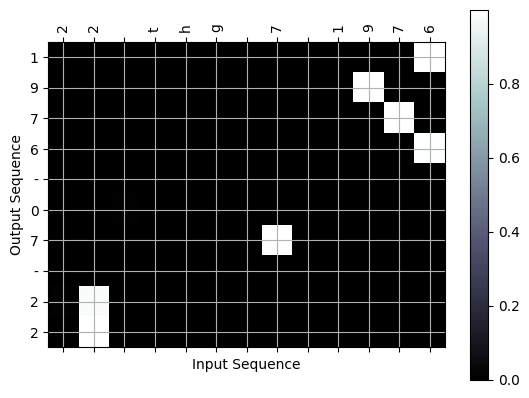

In [39]:
show_idx = randint(0, len(preds))
text_x = decoder_sentence(X_val[:,show_idx].numpy(), x_id2w)
text_y = decoder_sentence(preds[show_idx].numpy(), y_id2w)
attn_weight = attn_weights[show_idx, :, -len(text_x):]
show_attention(text_x, text_y, attn_weight)